In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
import itertools
from scipy.ndimage import median_filter
from matplotlib.colors import Normalize

In [2]:
h5_file_path = "F:/PhD_Franziska/Headon/RedBeads/capuchine_pigeon/PIV_capuchine_pigeon/"
with h5py.File(h5_file_path+"U_matrix", "r") as h5f:
    U = h5f["matrix"][:] # shape: frame, rows, columns 

with h5py.File(h5_file_path+"V_matrix", "r") as h5f:
    V = h5f["matrix"][:]

with h5py.File(h5_file_path+"M_matrix", "r") as h5f:
    M = h5f["matrix"][:]

with h5py.File(h5_file_path+"xgrid_matrix", "r") as h5f:
    xgrid = h5f["matrix"][:]

with h5py.File(h5_file_path+"ygrid_matrix", "r") as h5f:
    ygrid = h5f["matrix"][:]

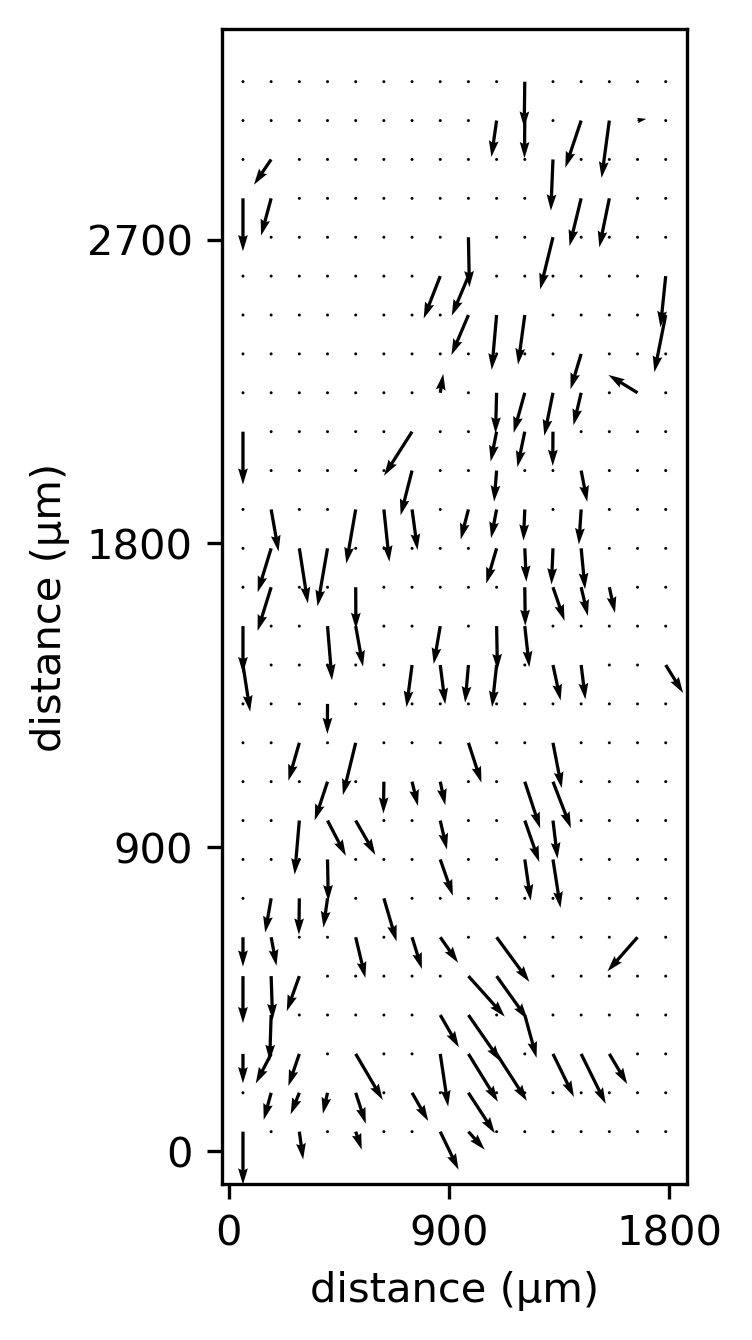

In [3]:
t = 69
pxl_conversion = 1.8

plt.figure(figsize=(2, 5), dpi=300)
plt.quiver(ygrid[t], xgrid[t], U[t], -V[t], width=0.007)
plt.xticks([0, 500, 1000], (np.array([0, 500, 1000])*pxl_conversion).astype(int))
plt.xlabel("distance (μm)")
plt.yticks([0, 500, 1000, 1500], (np.array([0, 500, 1000, 1500])*pxl_conversion).astype(int))
plt.ylabel("distance (μm)")
# plt.savefig("capuchine_pigeon_frame70.svg", format="svg")
plt.show()

# Calculate for each time point the mean vector of PIV vectors.

In [4]:
np.shape(U)
m_U = np.mean(U, axis=(1, 2))
m_V = np.mean(V, axis=(1, 2))
m_M = np.sqrt(m_U**2 + m_V**2)
np.shape(m_M)

(182,)

In [5]:
def mean_vector(U, V, pxl_conversion, time_conversion): 
    # Calculate for each time point the mean value of x and y components of vectors. 
    # U, V: (t, x, y) 3D numpy array containing PIV results. 

    mean_U = np.mean(U, axis=(1, 2))
    mean_V = np.mean(V, axis=(1, 2))

    # mean length of the vecotrs. 
    mean_length = np.sqrt(mean_U**2 + mean_V**2) * pxl_conversion / time_conversion

    return mean_U, mean_V, mean_length

# Plot the mean vector direction in rose plots and color coded with velocity.

In [6]:
# Calculate the mean velocity of the vectors that fall into the same bin in rose plot and color code based on the mean velocity.
def mean_each_bin_for_rose_plot(avg_u, avg_v, angles, bins, num_bins, pxl_conversion, time_conversion):
    # We can group the vectors into bins and retrieve their corresponding indices
    bin_indices = np.digitize(angles, bins) - 1  # Get bin index for each angle (0-indexed)
    vectors_in_bins = {i: [] for i in range(num_bins)}  # Dictionary to store x-component vectors for each bin
    
    # Store vectors in their corresponding bins
    for i, bin_idx in enumerate(bin_indices):
        vectors_in_bins[bin_idx].append((avg_u[i], avg_v[i]))

    # Calculate the mean vector length for each bin
    mean_lengths = {}
    for bin_idx, vectors in vectors_in_bins.items():
        # Calculate the length of each vector in this bin. Converted into real measure.
        lengths = [np.sqrt(x**2 + y**2) * pxl_conversion / time_conversion for x, y in vectors]
        
        # Compute the mean length for this bin
        if lengths:  # Ensure the bin is not empty
            mean_lengths[bin_idx] = np.mean(lengths)
        else:
            mean_lengths[bin_idx] = 0  # If no vectors, mean length is 0
    
    return np.array(list(mean_lengths.values()))

In [7]:
def rose_plot(U, V, pxl_conversion, time_conversion):
    # Having vectors in x and y components. Convert into angles. 
    # Hitogram counting the number of vectors with corresponding angle. -- for all frames contained in PIV matrix.  
    # center: [y, x] pixel coordinates for manually defined aggregate center. 
    # x, y: the rection components of the reference polarisation vector. 
    # reference_length: For visualisation of reference polarisation vector direction. Manually determine the length. 
    
    # Calculate the averaged surounding flow vectors for all frames contained in PIV matrix U. 
    avg_u, avg_v,_ = mean_vector(U, V, pxl_conversion, time_conversion)
    # Calculate angles for each of the averaged flow vector. 
    angles = np.arctan2(-avg_v, avg_u)
    
    # Mean velocity of vectors that fall into the same bin. 
    num_bins = 50
    bins = np.linspace(-np.pi, np.pi, num_bins + 1)
    mean_for_bins = mean_each_bin_for_rose_plot(avg_u, avg_v, angles, bins, num_bins, pxl_conversion, time_conversion)

    # Create the polar plot, with histogram counting the number of vectors pointing to the corresponding direction. 
    # Histogram bars are colored by the mean velocity of vectors in each bar/bin. 
    fig = plt.figure(figsize=(3, 3), dpi=300)
    ax = plt.subplot(111, projection='polar')
    # Create the histogram (rose plot) and get the patches (bars) and bin edges.
    counts, bin_edges, patches = ax.hist(angles, bins=num_bins, range=(-np.pi, np.pi)) #, edgecolor='white')
    
    # Normalize the custom values for color mapping
    norm = Normalize(vmin=min(mean_for_bins), vmax=max(mean_for_bins))
    cmap = plt.get_cmap('Grays')
    
    # Color each bar based on its corresponding custom value.
    for patch, custom_value in zip(patches, mean_for_bins):
        patch.set_facecolor(cmap(norm(custom_value)))

    # Show colorbar with setting of position by pad and size by fraction. 
    cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm), ax=ax, fraction=0.04, pad=0.15)
    cbar.set_label("mean velocity (μm/min)")

    plt.savefig("capuchine_pigeon_red_beads.svg", format="svg")

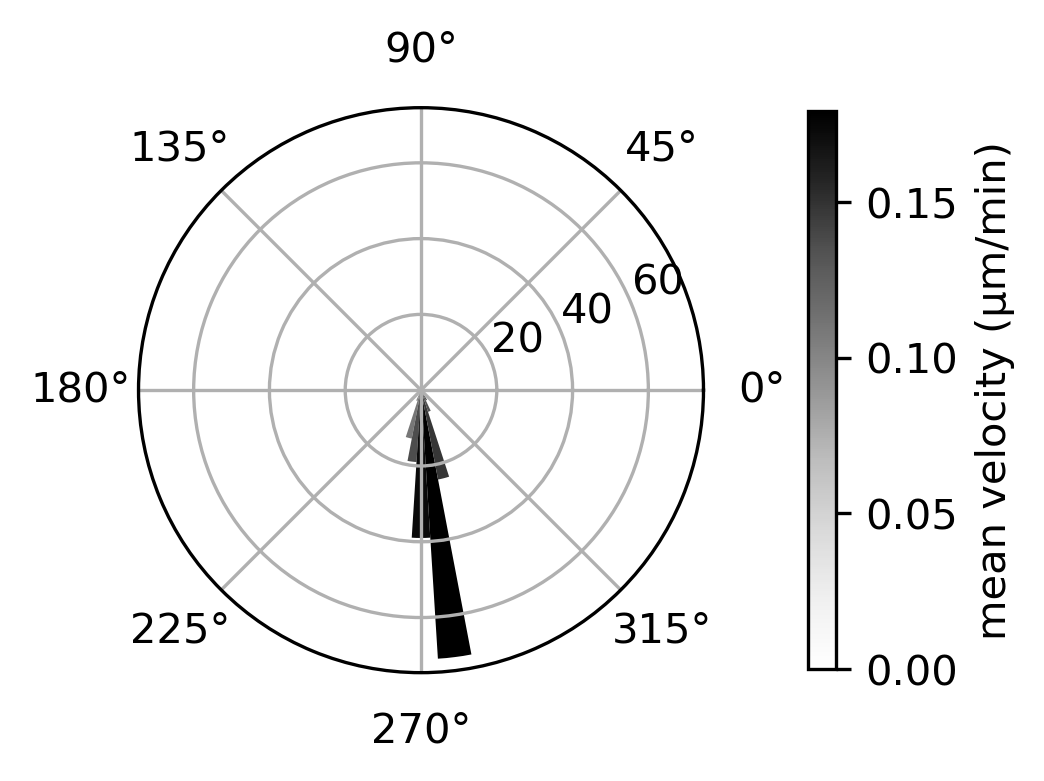

In [8]:
rose_plot(U, V, 1.8, 15)